In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [4]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,Data/images/N199.xml,45,112,206,255
1,Data/images/N242.xml,202,386,190,227
2,Data/images/N229.xml,358,1031,294,540
3,Data/images/N148.xml,244,369,240,293
4,Data/images/N63.xml,297,422,174,218


In [5]:
import xml.etree.ElementTree as xet

In [6]:
filename = df['filepath'][0]
filename

'Data/images/N199.xml'

In [7]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('Data/images',filename_image)
    return filepath_image

In [8]:
getFilename(filename)

'Data/images/N199.jpeg'

In [9]:
image_path = list(df['filepath'].apply(getFilename))
image_path 

['Data/images/N199.jpeg',
 'Data/images/N242.jpeg',
 'Data/images/N229.jpeg',
 'Data/images/N148.jpeg',
 'Data/images/N63.jpeg',
 'Data/images/N21.jpeg',
 'Data/images/N62.jpeg',
 'Data/images/N239.jpeg',
 'Data/images/N121.jpeg',
 'Data/images/N73.jpeg',
 'Data/images/N82.jpeg',
 'Data/images/N133.jpeg',
 'Data/images/N17.jpeg',
 'Data/images/N25.jpeg',
 'Data/images/N142.jpeg',
 'Data/images/N19.jpeg',
 'Data/images/N46.jpeg',
 'Data/images/N126.jpeg',
 'Data/images/N236.jpeg',
 'Data/images/N209.jpeg',
 'Data/images/N215.jpeg',
 'Data/images/N31.jpeg',
 'Data/images/N164.jpeg',
 'Data/images/N213.jpeg',
 'Data/images/N179.jpeg',
 'Data/images/N186.jpeg',
 'Data/images/N79.jpeg',
 'Data/images/N131.jpeg',
 'Data/images/N134.jpeg',
 'Data/images/N210.jpeg',
 'Data/images/N222.jpeg',
 'Data/images/N1.jpeg',
 'Data/images/N20.jpeg',
 'Data/images/N191.jpeg',
 'Data/images/N81.jpeg',
 'Data/images/N220.jpeg',
 'Data/images/N241.jpeg',
 'Data/images/N165.jpeg',
 'Data/images/N74.jpeg',
 '

#### verify image and output

In [10]:
file_path = image_path[0]
file_path 

'Data/images/N199.jpeg'

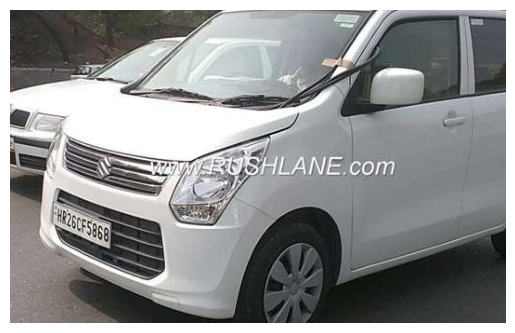

In [11]:
# img = cv2.imread(file_path)

# cv2.namedWindow('example',cv2.WINDOW_NORMAL)
# cv2.imshow('example',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()



import cv2
import matplotlib.pyplot as plt

img = cv2.imread(file_path)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display inline in the notebook
plt.imshow(img_rgb)
plt.axis('off')  # Optional: hides the axis rulers
plt.show()

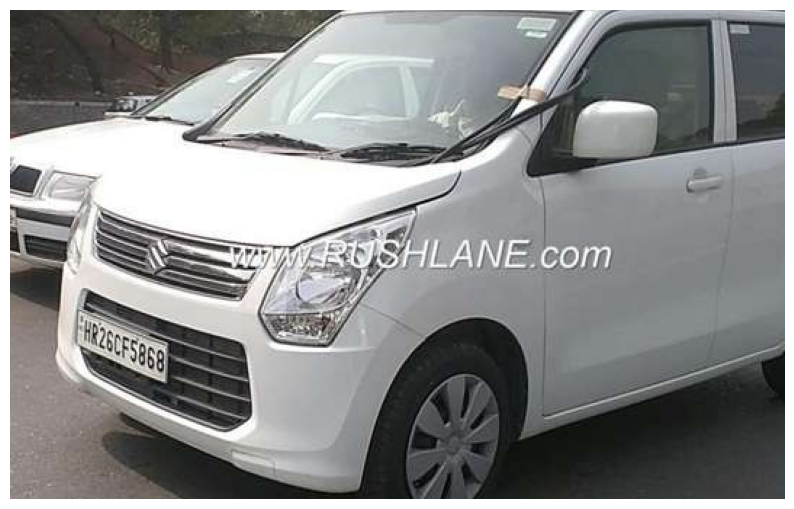

In [12]:
# # 1093	1396	645	727
# cv2.rectangle(img,(1093,645),(1396,727),(0,255,0),3)
# cv2.namedWindow('example',cv2.WINDOW_NORMAL)
# cv2.imshow('example',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


import cv2
import matplotlib.pyplot as plt

# 1. Your drawing code (remains the same)
# Coordinates: (1093, 645) to (1396, 727)
cv2.rectangle(img, (1093, 645), (1396, 727), (0, 255, 0), 3)

# 2. FIX: Convert BGR (OpenCV) to RGB (Matplotlib)
# If you skip this, the green box will look purple/pink
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 3. FIX: Display inline instead of using cv2.imshow
plt.figure(figsize=(10, 8)) # Optional: makes the image larger in the notebook
plt.imshow(img_rgb)
plt.axis('off')             # Optional: hides the x/y pixel rulers
plt.show()

### Data Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [14]:
labels = df.iloc[:,1:].values

In [15]:
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    # normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    # -------------- append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [16]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [17]:
X.shape,y.shape

((225, 224, 224, 3), (225, 4))

In [18]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

### Deep Learning Model

In [19]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [22]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)
# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [23]:
# complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_203[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_203[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_204[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_204[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_205[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_205[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_206 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_206[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_207 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_206[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_207[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 73,663,490 (281.00 MB)

 Trainable params: 19,326,754 (73.73 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

### model training

In [24]:
from tensorflow.keras.callbacks import TensorBoard

In [25]:
tfb = TensorBoard('object_detection')

In [27]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 3.7780e-04 - val_loss: 0.0069
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.3082e-04 - val_loss: 0.0069
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.6083e-04 - val_loss: 0.0068
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.2982e-04 - val_loss: 0.0069
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.2186e-04 - val_loss: 0.0071
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.3870e-04 - val_loss: 0.0068
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.5597e-04 - val_loss: 0.0069
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.8285e-04 - val_loss: 0.0068
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.0444e-04 - val_loss: 0.0069
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.8337e-04 - val_loss: 0.0070
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 2.4730e-04 - val_loss: 0.0069
Epoch 12

In [28]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=200,
                    validation_data=(x_test,y_test),callbacks=[tfb],initial_epoch=101)

Epoch 102/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.0187e-04 - val_loss: 0.0066
Epoch 103/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.0670e-05 - val_loss: 0.0066
Epoch 104/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.3350e-05 - val_loss: 0.0065
Epoch 105/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.0781e-05 - val_loss: 0.0066
Epoch 106/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 8.6300e-05 - val_loss: 0.0066
Epoch 107/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 7.7770e-05 - val_loss: 0.0068
Epoch 108/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.2884e-04 - val_loss: 0.0063
Epoch 109/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.6447e-04 - val_loss: 0.0065
Epoch 110/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.7763e-04 - val_loss: 0.0065
Epoch 111/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.7363e-04 - val_loss: 0.0066
Epoch 112/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.7363e-04 - val_l

In [30]:
model.save('./models/object_detection.h5')

model.save('./models/object_detection.keras')